In [1]:
from pdbbind_dock import PDBresult
from tqdm import tqdm
import zarr

store = zarr.open('formatted_results.zarr', 'r')

all_pdbs = []
for pdb in store:
    all_pdbs.append(pdb)

nres = {}
poses = {}
poses_relax = {}
poses_ligaway = {}

fails = 0
good_pdbs = []

for pdb in tqdm(all_pdbs[:]):
    pdb_entry = PDBresult( store, pdb )
    if not pdb_entry.healthy:
        fails += 1
        continue

    try:
        pose = pdb_entry.get_complex('pose')
        nres[pdb] = pose.get_n_res()
        pose.pdb = None
        pose.rdkit_mol = None
        poses[pdb] = pose
    except:
        fails += 1
        continue

    try:
        pose = pdb_entry.get_complex('pose_relax')
        pose.pdb = None
        pose.rdkit_mol = None
        poses_relax[pdb] = pose
    except:
        fails += 1
        continue

    try:
        pose = pdb_entry.get_complex('pose_relax_ligaway')
        pose.pdb = None
        pose.rdkit_mol = None
        poses_ligaway[pdb] = pose
    except:
        fails += 1
        continue

    good_pdbs.append(pdb)

print(fails, "pdbs failed or are incomplete")
print(len(good_pdbs), "are flawless")

 41%|████      | 7983/19443 [26:44<37:17,  5.12it/s]  [21:10:27] bond with order 0 found on line 48. This is not part of the MDL specification.
[21:10:27] bond with order 0 found on line 48. This is not part of the MDL specification.
[21:10:27] bond with order 0 found on line 48. This is not part of the MDL specification.
 41%|████      | 7991/19443 [26:46<49:32,  3.85it/s][21:10:29] bond with order 0 found on line 50. This is not part of the MDL specification.
[21:10:29] bond with order 0 found on line 50. This is not part of the MDL specification.
[21:10:29] bond with order 0 found on line 50. This is not part of the MDL specification.
 45%|████▍     | 8697/19443 [29:16<36:35,  4.90it/s]  [21:12:59] bond with order 0 found on line 96. This is not part of the MDL specification.
[21:12:59] bond with order 0 found on line 96. This is not part of the MDL specification.
[21:12:59] bond with order 0 found on line 96. This is not part of the MDL specification.
 52%|█████▏    | 10180/19443 [

955 pdbs failed or are incomplete
18488 are flawless


In [24]:
import pickle

with open( 'nres.pickle', 'wb' ) as f:
    pickle.dump(nres, f)

with open( 'poses.pickle', 'wb' ) as f:
    pickle.dump(poses, f)

with open( 'poses_relax.pickle', 'wb' ) as f:
    pickle.dump(poses_relax, f)

with open( 'poses_ligaway.pickle', 'wb' ) as f:
    pickle.dump(poses_ligaway, f)

In [1]:
import pickle

with open( 'nres.pickle', 'rb' ) as f:
    nres = pickle.load(f)

with open( 'poses.pickle', 'rb' ) as f:
    poses = pickle.load(f)

with open( 'poses_relax.pickle', 'rb' ) as f:
    poses_relax = pickle.load(f)

with open( 'poses_ligaway.pickle', 'rb' ) as f:
    poses_ligaway = pickle.load(f)

good_pdbs = list( poses_ligaway.keys() )
len(good_pdbs)

18488

In [2]:
# loading kd scores from lppdbbind

import pandas as pd

units = [ 'mM', 'uM', 'nM', 'pM', 'fM', 'BAD' ]

df = pd.read_csv('LP_PDBBind.csv', index_col=0)

clean_kds = {}

for pdb in list(df[~df.covalent].index):
    aff = df.loc[pdb]['kd/ki']
    if "Kd=" in aff or "Ki=" in aff:
        val = float(aff.split('=')[1][:-2])
        unit = aff.split('=')[1][-2:]
        for u in units:
            val /= 1000
            if unit == u:
                break
        clean_kds[pdb] = val
        if u == 'BAD':
            print(aff, unit)

kd_arr = [ clean_kds[x] for x in clean_kds  ]

print(min(kd_arr), max(kd_arr))

import math

dGs = {}
for pdb in clean_kds:
    kd = clean_kds[pdb]
    dG = -1.987 * 298.15 * math.log( kd ) / 1000
    dGs[ pdb ] = dG

dG_arr = [ dGs[x] for x in dGs ]
print(min(dG_arr), max(dG_arr))

6e-16 0.4
0.542832666354351 20.76422717879261


In [8]:
import zarr
from pdbbind_dock import PDBresult

store = zarr.open('formatted_results.zarr', 'r')

In [ ]:
# figure usefull pdb labels out

# flawless pdbs from docking
# non covalent bound pdbs
# pdbs with Kd and Ki
# ligands with qed > 0.2

# according to LPPDBbind this might still include ligand and/or receptors with low occurence atom elements

clean_pdbs = [ pdb for pdb in clean_kds if pdb in good_pdbs ]
print( len(good_pdbs), len(clean_kds), len(clean_pdbs) )

from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm import tqdm

druglike_clean_pdbs = []

removed_mols = []
fails = 0

for pdb in tqdm(clean_pdbs):
    smiles = df.loc[pdb]['smiles']
    try:
        try:
            mol = Chem.MolFromSmiles(smiles)
        except:
            mol = PDBresult(store, pdb).get_complex('pose').rdkit_mol
        qed=Descriptors.qed(mol)
    except:
        qed=-99999.9
        fails += 1
    if qed >= 0.2:
        druglike_clean_pdbs.append(pdb)
    elif qed > -1000:
        removed_mols.append( (qed, mol) )

print(len(druglike_clean_pdbs), len(removed_mols), fails)

18488 11570 10915


  1%|▏         | 150/10915 [00:00<00:22, 483.90it/s][10:00:56] Can't kekulize mol.  Unkekulized atoms: 22 23 24 27 30 31
[10:00:56] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
  4%|▎         | 399/10915 [00:01<00:29, 362.61it/s][10:00:57] Can't kekulize mol.  Unkekulized atoms: 4 7 8 9 10 11
[10:00:57] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
  7%|▋         | 804/10915 [00:02<00:22, 452.04it/s][10:00:58] Can't kekulize mol.  Unkekulized atoms: 21 22 25 28 31 32
[10:00:58] Can't kekulize mol.  Unkekulized atoms: 18 19 20 23 26 27
 40%|███▉      | 4329/10915 [00:15<00:25, 262.03it/s][10:01:10] Can't kekulize mol.  Unkekulized atoms: 22 23 24 27 30 31
[10:01:11] Can't kekulize mol.  Unkekulized atoms: 15 17 18
 40%|████      | 4376/10915 [00:15<00:28, 226.54it/s][10:01:11] Can't kekulize mol.  Unkekulized atoms: 6 16 29 35 44 49 54 56 58
[10:01:11] Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 38 41
 41%|████▏     | 4515/10915 [00:16<00:34, 185.76it/s][10:01

7754 2961 200


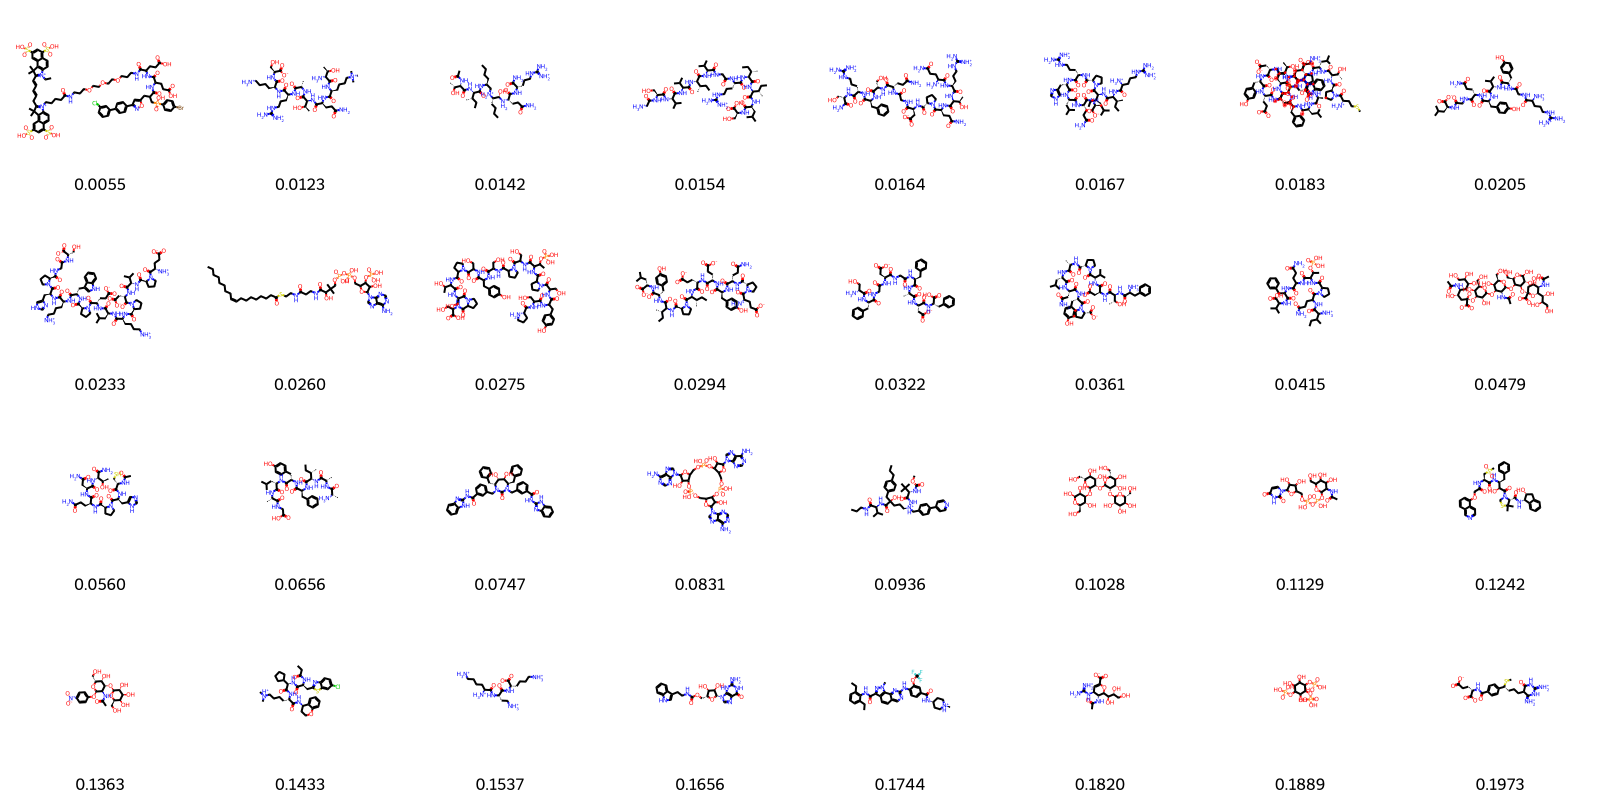

In [23]:
from rdkit.Chem import Draw

removed_mols.sort(key=lambda x: x[0])
mol_list = []
qeds = []

nmols = 32

for i in range(nmols):
    i /= nmols
    i = int(i*len(removed_mols))
    m = removed_mols[i][1]
    qed = removed_mols[i][0]
    mol_list.append(m)
    qeds.append(f'{qed:.4f}')

img = Draw.MolsToGridImage( mol_list, legends=qeds, molsPerRow=8 )
img


In [25]:
# check for low occurence elements



common_receptor_atoms = ["C","S","O","N","ZN","CA","CO","MG","NI","MN","FE","NA","K","SE","P","CD","H"]
common_ligand_atoms = ["C","S","O","N","CL", "P", "F", "BR", "I", "B","H"]

all_clean_pdbs = []

for pdb in tqdm(clean_pdbs):
    pdb_entry = PDBresult( store, pdb )
    pdb_string = pdb_entry.get_complex('pose').pdb
    receptor_elems = set()
    ligand_elems = set()
    for line in pdb_string.split('\n'):
        if line[:4] == 'ATOM':
            receptor_elems.add( line[76:78].upper().strip() )
        elif line[:6] == 'HETATM' and line[17:20] == 'UNK':
            ligand_elems.add( line[76:78].upper().strip() )
    bad = False
    for e in receptor_elems:
        if e not in common_receptor_atoms:
            print(pdb, 'receptor has', e)
            bad = True
    for e in ligand_elems:
        if e not in common_ligand_atoms:
            print(pdb, 'ligand has', e)
            bad = True
    if not bad:
        all_clean_pdbs.append( pdb )

print(len(all_clean_pdbs))

 48%|████▊     | 5207/10915 [18:19<22:02,  4.32it/s]

5dhf ligand has SE


 48%|████▊     | 5280/10915 [18:34<20:13,  4.64it/s]

5m29 ligand has CO


 49%|████▉     | 5325/10915 [18:43<16:08,  5.77it/s]

6d1m ligand has SE


 50%|████▉     | 5409/10915 [18:59<20:12,  4.54it/s]

1lvk ligand has BE


 54%|█████▍    | 5941/10915 [20:52<15:31,  5.34it/s]

5m34 ligand has CO


 55%|█████▌    | 6010/10915 [21:07<16:39,  4.91it/s]

5fjw ligand has SE


 55%|█████▌    | 6011/10915 [21:07<19:18,  4.23it/s]

4jjf ligand has FE


 56%|█████▋    | 6144/10915 [21:33<15:22,  5.17it/s]

6i97 ligand has FE


 57%|█████▋    | 6175/10915 [21:40<17:01,  4.64it/s]

5tgy ligand has ZN


 58%|█████▊    | 6332/10915 [22:11<14:12,  5.37it/s]

5fsb ligand has SE


 59%|█████▊    | 6391/10915 [22:22<13:19,  5.66it/s]

6hwz ligand has SE


 59%|█████▉    | 6448/10915 [22:35<15:36,  4.77it/s]

5nxx ligand has AS


 60%|██████    | 6573/10915 [23:00<13:39,  5.30it/s]

6h3q ligand has SE


 61%|██████    | 6620/10915 [23:11<14:49,  4.83it/s]

2v96 ligand has AS


 62%|██████▏   | 6729/10915 [23:33<13:34,  5.14it/s]

4fea ligand has CU


 62%|██████▏   | 6752/10915 [23:38<14:00,  4.95it/s]

6i96 ligand has FE


 68%|██████▊   | 7404/10915 [25:51<14:18,  4.09it/s][10:55:37] bond with order 0 found on line 90. This is not part of the MDL specification.
[10:55:37] bond with order 0 found on line 92. This is not part of the MDL specification.
 68%|██████▊   | 7405/10915 [25:52<14:46,  3.96it/s]

4kii ligand has RH


 69%|██████▉   | 7549/10915 [26:23<11:17,  4.97it/s]

3tdz ligand has SE


 71%|███████▏  | 7800/10915 [27:15<11:28,  4.52it/s]

6ceh ligand has SE


 72%|███████▏  | 7898/10915 [27:34<10:26,  4.82it/s]

4hmq ligand has FE


 73%|███████▎  | 7960/10915 [27:47<09:26,  5.22it/s]

4fil ligand has FE


 76%|███████▌  | 8277/10915 [28:51<07:46,  5.66it/s]

5nxy ligand has AS


 77%|███████▋  | 8372/10915 [29:10<08:33,  4.95it/s]

5m2q ligand has CO


 77%|███████▋  | 8392/10915 [29:13<05:47,  7.27it/s]

4z46 ligand has PT


 78%|███████▊  | 8473/10915 [29:31<09:32,  4.27it/s]

1k2v ligand has FE


 80%|███████▉  | 8709/10915 [30:20<06:18,  5.82it/s]

6pgx ligand has TE


 80%|████████  | 8780/10915 [30:35<07:35,  4.69it/s]

1esz ligand has FE


 82%|████████▏ | 8974/10915 [31:15<06:28,  5.00it/s]

6d1l ligand has SE


 84%|████████▎ | 9123/10915 [31:46<06:43,  4.44it/s]

3csl ligand has FE


 85%|████████▌ | 9280/10915 [32:19<07:20,  3.71it/s]

5m3b ligand has CO


 85%|████████▌ | 9326/10915 [32:28<03:57,  6.69it/s]

2wq4 ligand has SE


 86%|████████▌ | 9362/10915 [32:35<05:28,  4.72it/s]

1y3g ligand has SI


 87%|████████▋ | 9532/10915 [33:11<04:29,  5.14it/s]

6abk ligand has SI


 89%|████████▊ | 9675/10915 [33:42<06:00,  3.44it/s]

2z97 ligand has FE


 93%|█████████▎| 10130/10915 [35:15<02:50,  4.61it/s]

6frj ligand has SE


 93%|█████████▎| 10145/10915 [35:17<02:22,  5.41it/s]

4dcx ligand has FE


 96%|█████████▌| 10475/10915 [36:27<01:27,  5.03it/s]

6hx5 ligand has SE


100%|██████████| 10915/10915 [38:00<00:00,  4.79it/s]

10878


In [ ]:
# Pandas dataframe features
# pdbcode,lppdbbind_split,affinity_type,dG,covalent,fully_relaxed,nres,qed,has_rare_element
#
# crl: crystal, relaxed, ligaway
# rosetta values: relax rmsd to crystal, crl total score, cr idelta, cr raw delta energies, rl raw energies
#
# Additionally: Safe pdb files and sdf (with correct coordinates!)

In [8]:
with open( 'all_clean_pdbs.pickle', 'wb' ) as f:
    pickle.dump(all_clean_pdbs, f)

-254.5787501848021 10770.945289621051
-1265424452.0109248 494.02766415746913
-139.9618003863543 636.6766484603604
-62.99935907728204 197.9908613146519
-81.19320797622464 95.78068103014867
-99.7998305113332 187.35864848328174
187
10
8


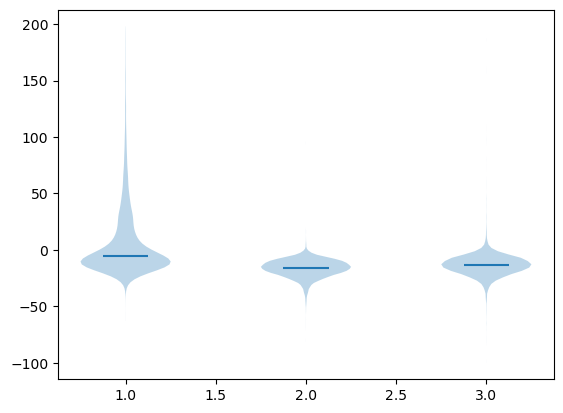

In [26]:
import matplotlib.pyplot as plt

crystal_score = [ poses[ x ].idelta_score for x in all_clean_pdbs ]
relax_score = [ poses_relax[ x ].idelta_score for x in all_clean_pdbs ]
ligaway_score = [ poses_relax[ x ].total_score - poses_ligaway[ x ].total_score for x in all_clean_pdbs ]

print(min(crystal_score), max(crystal_score))
print(min(relax_score), max(relax_score))
print(min(ligaway_score), max(ligaway_score))

crystal_score_filter = [ x for x in crystal_score if x > -100 and x < 200 ]
relax_score_filter = [ x for x in relax_score if x > -100 and x < 200 ]
ligaway_score_filter = [ x for x in ligaway_score if x > -100 and x < 200 ]

print(min(crystal_score_filter), max(crystal_score_filter))
print(min(relax_score_filter), max(relax_score_filter))
print(min(ligaway_score_filter), max(ligaway_score_filter))

print(len(crystal_score) - len(crystal_score_filter))
print(len(relax_score) - len(relax_score_filter))
print(len(ligaway_score) - len(ligaway_score_filter))

plt.violinplot( [crystal_score_filter, relax_score_filter, ligaway_score_filter], showmedians=True, showextrema=False )
#plt.ylim(-20, 5)
plt.show()

22.93994803315429


(-25.0, 5.0)

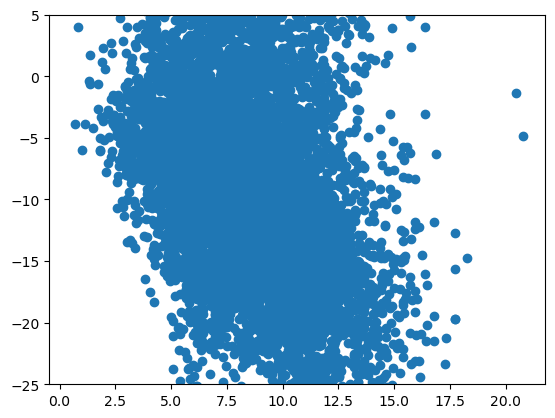

In [ ]:
#crystal_score = [ poses[ x ].idelta_score for x in all_clean_pdbs ]
#relax_score = [ poses_relax[ x ].idelta_score for x in all_clean_pdbs ]
#ligaway_score = [ poses_relax[ x ].total_score - poses_ligaway[ x ].total_score for x in all_clean_pdbs ]

x = []
y = []
errors = []

for pdb in all_clean_pdbs:
    #pred = poses_relax[ pdb ].total_score - poses_ligaway[ pdb ].total_score
    #pred = poses_relax[ pdb ].idelta_score
    pred = poses[ pdb ].idelta_score
    if pred > -200 and pred < 200:
        x.append( dGs[pdb] )
        y.append( pred )
        errors.append( abs(pred - dGs[pdb]) )
print(sum(errors)/len(errors))
plt.scatter(x, y)
#plt.ylim(-25,5)

-4.103834154288274 48.14868869986457
-5.241233904590781 1.2022972072930163
-5.1332593272000375 1.2511564514923343


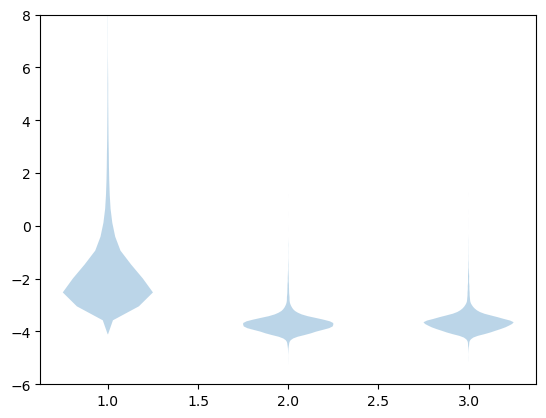

In [42]:
crystal_score = [ poses[ x ].total_score / nres[x] for x in all_clean_pdbs ]
relax_score = [ poses_relax[ x ].total_score / nres[x] for x in all_clean_pdbs ]
ligaway_score = [ poses_ligaway[ x ].total_score / nres[x] for x in all_clean_pdbs ]

print(min(crystal_score), max(crystal_score))
print(min(relax_score), max(relax_score))
print(min(ligaway_score), max(ligaway_score))

plt.violinplot( [crystal_score, relax_score, ligaway_score], showextrema=False )
plt.ylim(-6, 8)
plt.show()

-8720.55248977059 47790.856225464886
-15804.68115716288 276.5283576773937
-15664.719356776526 287.7659838432369


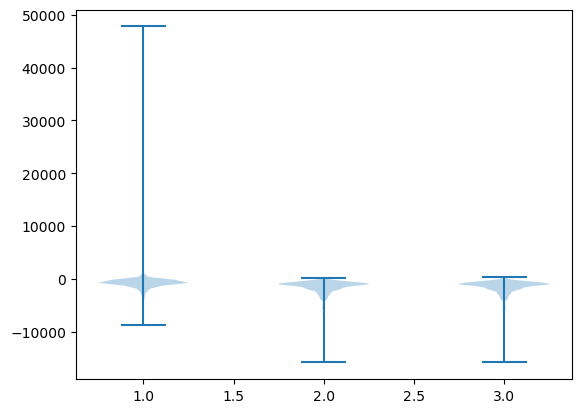

In [39]:
crystal_score = [ poses[ x ].total_score for x in all_clean_pdbs ]
relax_score = [ poses_relax[ x ].total_score for x in all_clean_pdbs ]
ligaway_score = [ poses_ligaway[ x ].total_score for x in all_clean_pdbs ]

print(min(crystal_score), max(crystal_score))
print(min(relax_score), max(relax_score))
print(min(ligaway_score), max(ligaway_score))

plt.violinplot( [crystal_score, relax_score, ligaway_score] )
#plt.ylim(-6, 5)
plt.show()

229


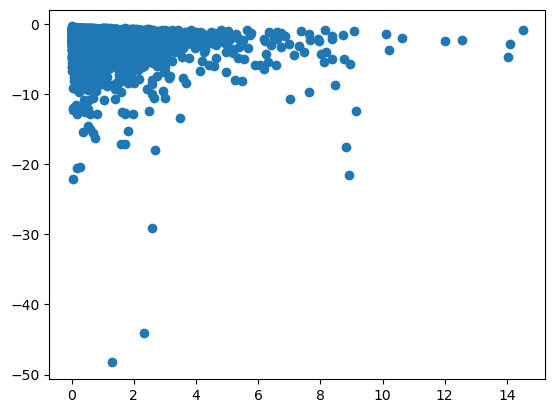

In [35]:
rmsd = [ poses_relax[x].rmsd_to_crystal for x in all_clean_pdbs ]
print(len([x for x in rmsd if x > 3]))
relax_delta = [ (poses_relax[ x ].total_score - poses[ x ].total_score) / nres[x] for x in all_clean_pdbs ]

plt.scatter( rmsd, relax_delta )

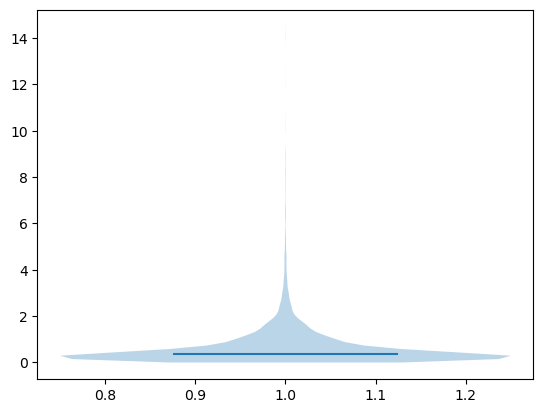

In [34]:
plt.violinplot(rmsd, showmedians=True, showextrema=False)
#plt.ylim(0,5)
plt.show()

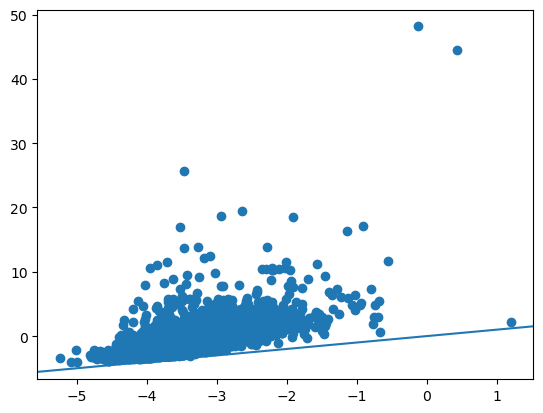

In [37]:
plt.scatter(relax_score, crystal_score)
plt.axline((1,1),(0,0))
#plt.ylim(-10000,10000)